# **Loan Data Analysis using Lending Club Data**

In [1]:
# Imports
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling

pd.set_option('display.max_rows', None,'display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# ignore Deprecation Warning
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning) 
warnings.filterwarnings("ignore") 

# Table of Contents
1. [Introduction](#intro)
2. [Import the data](#importdata)
3. [Target Variable](#targetvariable)
4. [Feature Selection](#featureselection)  
    4.1 [Drop single-value columns](#single_value)  
    4.2 [Remove columns with > 98% missing data](#missing_data)  
    4.3 [Remove irrelevant features](#irrelevant)   
    4.4 [Remove "cheat" features](#cheat)  
    4.5 [inspect non-numerical features](#non-numerical)  

Additionally: 
[MyGitHub](https://github.com/yanxiali)

## 1. Introduction
<a id="intro"></a>
In this project, I would like to make predictions on whether or not a load will be fully paid or charged off. 

## 2. Import the data
<a id="importdata"></a>

[Data source](https://www.kaggle.com/wordsforthewise/lending-club)


In [2]:
#df = pd.read_csv('../input/accepted_2007_to_2017Q3.csv.gz',compression='zip',low_memory=True)

In [3]:
df = pd.read_csv('../input/accepted_2017.csv.gz',compression='gzip',low_memory=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324931 entries, 0 to 324930
Columns: 150 entries, id to settlement_term
dtypes: float64(114), int64(1), object(35)
memory usage: 371.9+ MB


In [5]:
df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
164330,96951160,NaN,35000.0,35000.0,35000.0,36 months,19.99,1300.55,D,D4,Director of Nursing,10+ years,MORTGAGE,75000.0,Verified,Feb-2017,Current,n,NaN,debt_consolidation,Debt consolidation,380xx,TN,34.45,1.0,Sep-2000,680.0,684.0,0.0,13.0,NaN,11.0,0.0,11321.0,92.8,39.0,w,26582.88,26582.88,13650.11,13650.11,8417.12,5200.51,32.48,0.0,0.0,Dec-2017,1300.55,Jan-2018,Dec-2017,684.0,680.0,0.0,32.0,1.0,Individual,NaN,NaN,NaN,0.0,62.0,266104.0,1.0,5.0,1.0,3.0,12.0,169031.0,78.0,1.0,2.0,7511.0,81.0,12200.0,4.0,0.0,3.0,5.0,26610.0,0.0,101.1,0.0,0.0,196.0,166.0,1.0,1.0,2.0,14.0,NaN,3.0,32.0,1.0,2.0,3.0,2.0,3.0,27.0,5.0,10.0,3.0,11.0,0.0,0.0,0.0,2.0,94.7,100.0,0.0,0.0,287463.0,180352.0,10500.0,184354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
96277,105151171,NaN,20000.0,20000.0,20000.0,36 months,8.24,628.95,B,B1,NaN,10+ years,MORTGAGE,70000.0,Not Verified,Apr-2017,Current,n,NaN,debt_consolidation,Debt consolidation,303xx,GA,15.48,0.0,Nov-2004,725.0,729.0,0.0,NaN,NaN,4.0,0.0,14411.0,68.3,6.0,f,15971.24,15971.24,5022.44,5022.44,4028.76,993.68,0.00,0.0,0.0,Dec-2017,628.95,Jan-2018,Dec-2017,814.0,810.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,203413.0,0.0,0.0,0.0,0.0,46.0,0.0,NaN,1.0,1.0,9142.0,68.0,21100.0,0.0,0.0,0.0,1.0,50853.0,1312.0,90.5,0.0,0.0,46.0,146.0,12.0,12.0,1.0,12.0,NaN,NaN,NaN,0.0,2.0,3.0,2.0,2.0,1.0,3.0,4.0,3.0,4.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,238600.0,14411.0,13800.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [7]:
missing_values_table(df)

Your selected dataframe has 150 columns.
There are 62 columns that have missing values.


,Missing Values,% of Total Values
member_id,324931,100.0
desc,324931,100.0
debt_settlement_flag_date,324788,100.0
settlement_percentage,324788,100.0
settlement_amount,324788,100.0
settlement_date,324788,100.0
settlement_status,324788,100.0
settlement_term,324788,100.0
orig_projected_additional_accrued_interest,324251,99.8
deferral_term,324180,99.8


There are a few columns missing a significant amount of values (>48.6%). These features will be dropped. 

## 3. Target Variable
<a id="targetvariable"></a>

We are trying to predict the loan_status column. Let's check the value distributions in this column first

In [8]:
df['loan_status'].value_counts()

Current               285047
Fully Paid             27576
Late (31-120 days)      5044
Charged Off             3036
In Grace Period         2661
Late (16-30 days)       1564
Default                    3
Name: loan_status, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. 
We will only keep the rows with loan_status being "fully paid" or "charged off". 

In [9]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [10]:
df['loan_status'].value_counts(normalize=False, dropna=False)

Fully Paid     27576
Charged Off     3036
Name: loan_status, dtype: int64

In [11]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.900823
Charged Off    0.099177
Name: loan_status, dtype: float64

About 90% (~27k) of the loans have been fully paid, and 10% (3k) have been charged off. This is a very unbalanced classification problem. 

In [12]:
# Next, I will convert the "loan_status" column to a 0/1 "charged off" column. 
#df['loan_status'] = df['loan_status'].apply(lambda s: np.float(s == 'Charged Off'))
#df2 = df['loan_status'].apply(lambda s: np.float(s == 'Charged Off'))
#df2.value_counts()

In [13]:
#df.rename(columns={'loan_status':'charged_off'}, inplace=True)

Our target variable is ready now. We have two classes to try to predict.

## 4. Feature Selection
<a id="featureselection"></a>

The raw data has 150 features, but not all of them are useful. 
Definitions of the columns are given in the Lending Club "Data Dictionary" [available here](https://www.lendingclub.com/info/download-data.action).

We will drop the features with the following criteria:
- More than 50% of the data is missing
- The feature would not have been available at the time of the loan application ("issue_d")

### 4.2 Remove columns with > 48% missing data
<a id="missing_data"></a>

In [14]:
missing_values_table(df)

Your selected dataframe has 150 columns.
There are 59 columns that have missing values.


,Missing Values,% of Total Values
member_id,30612,100.0
desc,30612,100.0
next_pymnt_d,30612,100.0
orig_projected_additional_accrued_interest,30601,100.0
hardship_dpd,30591,99.9
hardship_length,30591,99.9
hardship_status,30591,99.9
deferral_term,30591,99.9
hardship_amount,30591,99.9
hardship_start_date,30591,99.9


From this table, we can see that there is a huge gap between features missing some data and those missing lots of data. 
I chose 49% as the cutoff.

In [15]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.48].index)

In [16]:
print(drop_list)

['annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlem

In [17]:
len(drop_list)

44

In [18]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [19]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [20]:
df.shape

(30612, 106)

### 4.5 Remove features that were unavailable before lending a loan
<a id="non-numerical"></a>

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, we would like to remove the features that were unavailable fore lending a loan. 

In [21]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_

We check the definition of these features and drop the ones that would have not been availalbe before a load was lended. 

In [22]:
#drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'recoveries', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

In [23]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

In [24]:
len(drop_list)

76

In [25]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [26]:
df.shape

(30612, 30)

### Inspect the remaining features
- Cleaning & Formatting: 
    - Histogram of the to-be-checked feature & its relation to the target variable.  
- Transformation of features
- choose the most relevant features in the data

I will start with defining some useful plotting functions, including:
1. single value plots + relationships with the loan_status
2. relationships between variables: Pearson correlation coefficient. 
3. pairs plot

In [27]:
def plot_var(col_name, full_name, continuous):
    """ 
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10,2))
    # plot without loan status
    if continuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    # plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        fully_paid_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Fully Paid']
        sns.barplot(x=fully_paid_rates.index, y=fully_paid_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Fully Paid')
        ax2.set_title('Fully Paid Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

In [28]:
#def plot_coeff

In [29]:
#def plot_pairs

What are the remaining features?

In [30]:
print(list(df.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'pub_rec', 'initial_list_status', 'policy_code', 'application_type', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies']


Next, I will check this features one by one. 

## id
Data Dictionary: "A unique assigned ID for the loan listing."

In [31]:
df['id'].sample(5)

192847     96286028
190072     96373470
315556    112050755
175261     96663451
114963    102617495
Name: id, dtype: int64

In [32]:
len(df['id'])

30612

In [33]:
len(df['id'].unique())

30612

"id" is a unique index. It's not useful as a categorical variable (so many unique values), nor as a numerical variable (a wild range of its values). Therefore I will drop this feature. 

In [34]:
df.drop(labels='id', axis=1, inplace=True)

## loan_amnt
Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [35]:
df['loan_amnt'].describe()

count    30612.000000
mean     14061.154939
std       9529.745282
min       1000.000000
25%       6400.000000
50%      12000.000000
75%      20000.000000
max      40000.000000
Name: loan_amnt, dtype: float64

"loan_amnt" range from \$1k to \$40 k, with a median of 12k. 

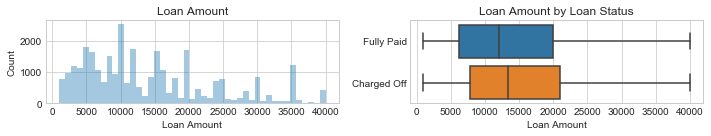

In [36]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

"Charged off" loans have higher loan amount. 

## term
Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [37]:
df['term'].sample(5)

35641      36 months
119628     36 months
925        36 months
242847     36 months
303128     36 months
Name: term, dtype: object

In [38]:
df['term'].value_counts(dropna=False)

 36 months    23414
 60 months     7198
Name: term, dtype: int64

We convert "term" to integers

In [39]:
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

In [40]:
df['term'].value_counts(normalize=True)

36    0.764863
60    0.235137
Name: term, dtype: float64

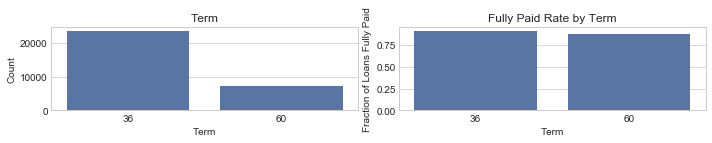

In [41]:
plot_var('term', 'Term', continuous=False)

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

## int_rate
Data Dictionary: "Interest Rate on the loan."

In [42]:
df['int_rate'].describe()

count    30612.000000
mean        14.536800
std          5.903335
min          5.320000
25%         10.910000
50%         13.490000
75%         16.990000
max         30.990000
Name: int_rate, dtype: float64

The interest rage ranges from 5% to 31%, with a median at 13%. 

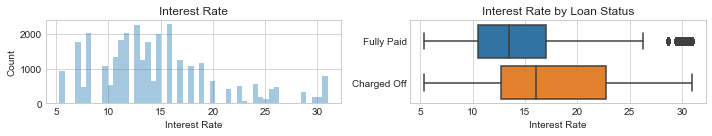

In [43]:
plot_var('int_rate', 'Interest Rate', continuous=True)

The higher the interest rate is, the more likely for being charged off. 

## installment
Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [44]:
df['installment'].describe()

count    30612.000000
mean       438.463252
std        297.664796
min         30.120000
25%        216.020000
50%        356.780000
75%        594.620000
max       1714.540000
Name: installment, dtype: float64

Installments range from \$30 to $1715, with a median at \$357. 

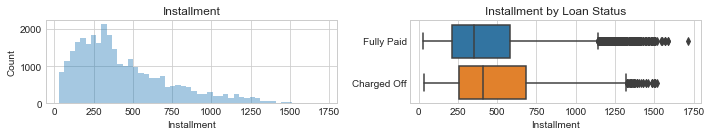

In [45]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments

## grade, sub_grade
Data Dictionary for grade: "assigned loan grade."
Data Dictionary for sub_grade: "LC assigned loan subgrade."

What are the possible values of grade and sub_grade?

In [46]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [47]:
print(sorted(df['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The "grade" is included in the "sub_grade" column, so it could be dropped.

In [48]:
df.drop(labels='grade',axis=1,inplace=True)

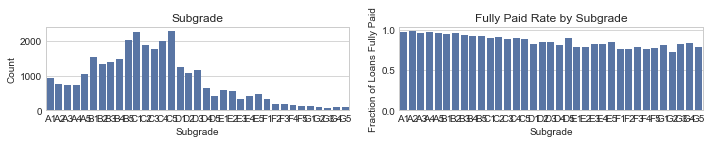

In [49]:
plot_var('sub_grade','Subgrade',continuous=False)

There is a trend of lower fraction of loans fully paid as the subgrade going from A to G.

## emp_title
Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [50]:
df['emp_title'].describe()

count       28553
unique      13990
top       Manager
freq          596
Name: emp_title, dtype: object

In [51]:
df['emp_title'].sample()

187210    Dsd driver 
Name: emp_title, dtype: object

There are too many unique titles for this feature to be useful, so we drop this feature. 

In [52]:
drop_cols('emp_title')

## emp_length
Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [53]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        1909
10+ years    10904
2 years       2742
3 years       2430
4 years       1826
5 years       1915
6 years       1387
7 years       1079
8 years        935
9 years       1158
< 1 year      2297
NaN           2030
Name: emp_length, dtype: int64

There are 2030 loans without the information on emp_length. Convert this feature to integers. 

In [54]:
df['emp_length'].replace('10+ years', '10 years', inplace=True)

In [55]:
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [56]:
df['emp_length'].value_counts(dropna=False).sort_index()

0 years      2297
1 year       1909
10 years    10904
2 years      2742
3 years      2430
4 years      1826
5 years      1915
6 years      1387
7 years      1079
8 years       935
9 years      1158
NaN          2030
Name: emp_length, dtype: int64

In [57]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts().sort_index()

0       2297
1       1909
10     10904
2       2742
3       2430
4       1826
5       1915
6       1387
7       1079
8        935
9       1158
nan     2030
Name: emp_length, dtype: int64

In [58]:
df['emp_length'] = df.emp_length.map( lambda x: str(x).split()[0])

In [59]:
df['emp_length'].sample(5)

218760     2
166716    10
129339     7
112971    10
185005     3
Name: emp_length, dtype: object

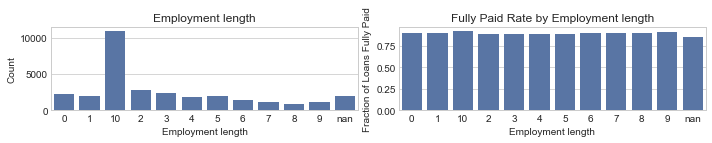

In [60]:
plot_var('emp_length', 'Employment length', continuous=False)

One third of the loans go to the people with longer than 10 years of employments. However, the fully paid rate seems not quite related to this feature. 

## home_ownership
Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [61]:
df['home_ownership'].value_counts()

MORTGAGE    16216
RENT        10442
OWN          3879
ANY            74
NONE            1
Name: home_ownership, dtype: int64

Replace "ANY" & "None" with "OTHERS". 

In [62]:
df['home_ownership'].replace(['NONE','ANY'],'OTHERS', inplace=True)

In [63]:
df['home_ownership'].value_counts()

MORTGAGE    16216
RENT        10442
OWN          3879
OTHERS         75
Name: home_ownership, dtype: int64

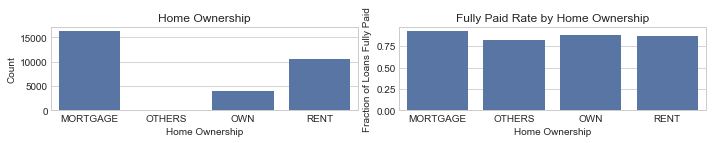

In [64]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be small differences in charge-off rates by home ownership status. Renters have slightly less probability of fully paying off the loan. Because of the large numbers of observations in each category, these differences are statistically significant.

## annual_inc
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [65]:
df['annual_inc'].describe()

count    3.061200e+04
mean     8.219195e+04
std      8.182641e+04
min      0.000000e+00
25%      5.000000e+04
50%      7.000000e+04
75%      1.000000e+05
max      8.300000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$8M, with a median at \$70k, which doubles the national median individual income in the US.
Due to the large range of variation, we log-transform the values.

In [66]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))

In [67]:
df['annual_inc'].describe()

count    30612.000000
mean         4.842359
std          0.266596
min          0.000000
25%          4.698979
50%          4.845104
75%          5.000004
max          6.919078
Name: annual_inc, dtype: float64

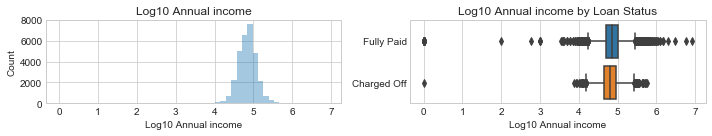

In [68]:
plot_var('annual_inc', 'Log10 Annual income', continuous=True)

Let's look closer of the difference here

In [69]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,3036.0,4.808561,0.262072,0.0,4.653222,4.812920,4.962438,5.767898
Fully Paid,27576.0,4.846080,0.266832,0.0,4.698979,4.845104,5.000004,6.919078


The difference in the median is ~\$5000, which is significant.

## verication_status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [73]:
df['verification_status'].value_counts()

Source Verified    12048
Not Verified       10032
Verified            8532
Name: verification_status, dtype: int64

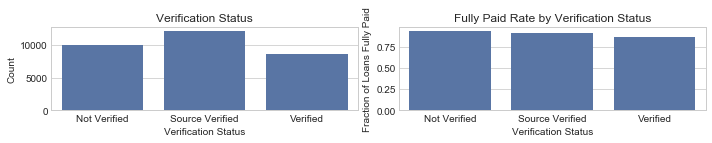

In [74]:
plot_var('verification_status', 'Verification Status', continuous=False)

## issue_d
Data Dictionary: "The month which the loan was funded.

Because we are only using the variables that are available before the loan was funded to make predictions, issue_d will not be included in modeling. This feature is kept here for train/test sample split, after which this feature will be dropped. 

## purpose
Data Dictionary: "A category provided by the borrower for the loan request."

In [75]:
df['purpose'].value_counts()

debt_consolidation    16577
credit_card            5629
home_improvement       2800
other                  2425
major_purchase          882
medical                 539
car                     462
vacation                365
moving                  328
small_business          311
house                   272
renewable_energy         22
Name: purpose, dtype: int64

Now let's check the fully paid rates of purposes.

In [81]:
df.groupby('purpose')['loan_status'].value_counts(normalize=True)[:,'Fully Paid'].sort_values(ascending=False)

purpose
house                 0.948529
car                   0.924242
credit_card           0.912773
home_improvement      0.908571
major_purchase        0.903628
vacation              0.901370
debt_consolidation    0.899620
other                 0.887010
moving                0.868902
renewable_energy      0.863636
medical               0.851577
small_business        0.823151
Name: loan_status, dtype: float64

We see that, 94% of the loans for house are fully paid, but only 82% of small business are fully paid.

## title
Data Dictionary: "The loan title provided by the borrower."

In [82]:
df['title'].value_counts()

Debt consolidation         16576
Credit card refinancing     5630
Home improvement            2800
Other                       2425
Major purchase               881
Medical expenses             539
Car financing                462
Vacation                     365
Moving and relocation        328
Business                     312
Home buying                  272
Green loan                    22
Name: title, dtype: int64

In [83]:
df['title'].describe()

count                  30612
unique                    12
top       Debt consolidation
freq                   16576
Name: title, dtype: object

In [84]:
df['title'].value_counts().head(10)

Debt consolidation         16576
Credit card refinancing     5630
Home improvement            2800
Other                       2425
Major purchase               881
Medical expenses             539
Car financing                462
Vacation                     365
Moving and relocation        328
Business                     312
Name: title, dtype: int64

There are 12 unique purposes in the dataset, and from the top 10 titles, it seems that this information is covered in the "purpose". So we drop this column. 

In [85]:
drop_cols('title')

## zip_code, addr_stat
Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."  
Data Dictionary for addr_state: "The state provided by the borrower in the loan application."  

In [87]:
df['zip_code'].describe()

count     30612
unique      828
top       945xx
freq        372
Name: zip_code, dtype: object

In [88]:
df['addr_state'].describe()

count     30612
unique       49
top          CA
freq       4567
Name: addr_state, dtype: object

There are many unique "zip_code" values, and the zip_code info should be equivalent to "addr_stat". Therefore we drop the "zip_code". 

### 4.1 Drop single-value columns
<a id="single_value"></a>

In [ ]:
def drop_single(dataframe):
    drop_list = []
    for col in dataframe.columns:
        if dataframe[col].nunique() == 1:
            drop_list.append(col)
    return drop_list   

In [ ]:
drop_list0 = drop_single(df)
print(drop_list0)

These columns do not contain any useful information so they can be dropped. 

In [ ]:
df.shape

In [ ]:
df.drop(labels=drop_list0, axis=1, inplace=True)

In [ ]:
df.shape

### 4.4 Remove "cheat" features
<a id="cheat"></a>

Some features imply the load status that the model is trying to predict. For example, if "debt_settlement_flag" is "Y", it implies that the borrower charged off. Also, if "total_pymnt" is greated than "loan_amnt" then the loan must be paid off. 

In [ ]:
#df.drop(labels=['collection_recovery_fee', 'debt_settlement_flag', 'last_pymnt_amnt', 'last_pymnt_d', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp'], axis=1, inplace=True)

In [ ]:
df.shape

### 4.5 Inspect non-numerical features
<a id="non-numerical"></a>

In [ ]:
df.head()

In [ ]:
text_cols = []
for col in df.columns:
    if df[col].dtype == np.object:
        text_cols.append(col)
text_cols

## Part I: Obtaining the Data
---

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# Read in the CSV file 
#DSLoanTrain = pd.read_csv('../data/loan-clean-version1.csv')
DSLoanTrain = pd.read_csv('../data/accepted_2007_to_2017Q3.csv')
DSLoanTrain.head()

In [ ]:
DSLoanTrain.dtypes

In [ ]:
DSLoanTrain[DSLoanTrain.isnull().any(axis=1)]

In [ ]:
class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['term']))}
DSLoanTrain['term']=DSLoanTrain['term'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['grade']))}
DSLoanTrain['grade']=DSLoanTrain['grade'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['emp_length']))}
DSLoanTrain['emp_length']=DSLoanTrain['emp_length'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['home_ownership']))}
DSLoanTrain['home_ownership']=DSLoanTrain['home_ownership'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['verification_status']))}
DSLoanTrain['verification_status']=DSLoanTrain['verification_status'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['purpose']))}
DSLoanTrain['purpose']=DSLoanTrain['purpose'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['addr_state']))}
DSLoanTrain['addr_state']=DSLoanTrain['addr_state'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['loan_status']))}
DSLoanTrain['loan_status']=DSLoanTrain['loan_status'].map(class_mapping)

In [ ]:
DSLoanTrain['emp_length'].value_counts()

In [ ]:
DSLoanTrain['loan_status'].value_counts()

In [ ]:
# encoding loan_status data by 'find and replace'
#cleanup_nums = {"loan_status": {"Fully Paid":1, "Charged Off":0}}
#DSLoanTrain.replace(cleanup_nums, inplace=True)
#DSLoanTrain.head()

In [ ]:
DSLoanTrain.head()

In [ ]:
DSLoanTrain = DSLoanTrain.select_dtypes(include=[np.number]).interpolate().dropna()
DSLoanTrain = DSLoanTrain.drop(["total_pymnt"], axis=1)
DSLoanTrain = DSLoanTrain.drop(["total_pymnt_inv"], axis=1)
DSLoanTrain = DSLoanTrain.drop(["total_rec_int"], axis=1)

In [ ]:
#
yPredict = DSLoanTrain.loan_status
XClean = DSLoanTrain.drop(["loan_status"], axis=1)

In [ ]:
#
X_train, X_test, y_train, y_test = train_test_split(XClean, yPredict, random_state=42, test_size=0.33)
#clf = RandomForestRegressor(n_jobs=2, n_estimators=1000)
#model = clf.fit(X_train, y_train)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train, y_train)

In [ ]:
predictions = mlp.predict(X_test)
print(confusion_matrix(y_test, predictions))

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
#
X_train, X_test, y_train, y_test = train_test_split(XClean, yPredict, random_state=42, test_size=.33)
clf = RandomForestRegressor(n_jobs=2, n_estimators=1000)
model = clf.fit(X_train, y_train)

In [ ]:
#
headers = ["name", "score"]
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x:x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))